In [1]:
import pandas as pd
df = pd.read_pickle("../merged_data.pkl")
df.head()

,CompanyNumber,yyyy,mm,DTDmedianFin,DTDmedianNonFin,dummy297fin,EventDate,EventDate_string,Duration,StartDate,...,equity_ratio,financial_leverage_ratio,cashflow_to_debt_ratio,net_profit_margin,asset_turnover,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,retention_ratio
0,26980,2000.0,5,0.0,2.190874,0.0,1970-01-12 01:52:19.200000+00:00,2000 05,4501 days 00:00:00,1970-01-07 13:50:52.800000+00:00,...,8.653470,0.115561,0.353320,0.496181,0.500283,0.439043,2.277680,6.329094,-10.552301,5.626957
1,26995,2000.0,12,0.0,1.863172,0.0,1970-01-12 07:00:28.800000+00:00,2000 12,4715 days 00:00:00,1970-01-07 13:50:52.800000+00:00,...,5.227711,0.191288,0.270503,0.309987,0.252043,5.105960,0.195850,-30.840000,98.727273,0.127184
2,27003,2000.0,6,0.0,2.257787,0.0,1970-01-12 02:36:57.600000+00:00,2000 06,4532 days 00:00:00,1970-01-07 13:50:52.800000+00:00,...,2.758440,0.362524,0.040856,0.553460,0.471932,0.027663,42.234378,1.449149,42.256637,13.899441
3,27058,2000.0,3,0.0,2.599548,0.0,1970-01-12 00:24:28.800000+00:00,2000 03,4440 days 00:00:00,1970-01-07 13:50:52.800000+00:00,...,0.977792,1.022712,0.154983,0.351704,1.000000,2.866751,0.348827,0.677361,14.625000,5.160377
4,27071,2000.0,4,0.0,2.318686,0.0,1970-01-12 01:09:07.200000+00:00,2000 04,4471 days 00:00:00,1970-01-07 13:50:52.800000+00:00,...,0.883145,1.132316,0.307483,0.303481,0.541856,1.503662,0.665043,3.567568,17.829861,14.014418


In [2]:
# Unnecessary cols
labels_to_drop = [
    'CompanyNumber',
    'EventDate',
    'EventDate_string',
    'StartDate',
    'gvkey',
    'datadate', 
    'yyyy',  
    'mm', 
]
df = df.drop(labels_to_drop, axis=1)
df.head()

,DTDmedianFin,DTDmedianNonFin,dummy297fin,Duration,EventType,sic,atq,ltq,dlcq,txditcq,...,equity_ratio,financial_leverage_ratio,cashflow_to_debt_ratio,net_profit_margin,asset_turnover,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,retention_ratio
0,0.0,2.190874,0.0,4501 days 00:00:00,0.0,3612.0,1498.445,734.978,2.442,0.00,...,8.653470,0.115561,0.353320,0.496181,0.500283,0.439043,2.277680,6.329094,-10.552301,5.626957
1,0.0,1.863172,0.0,4715 days 00:00:00,0.0,4513.0,12535.000,8196.000,230.000,1156.00,...,5.227711,0.191288,0.270503,0.309987,0.252043,5.105960,0.195850,-30.840000,98.727273,0.127184
2,0.0,2.257787,0.0,4532 days 00:00:00,0.0,5411.0,9032.869,8359.571,474.892,0.00,...,2.758440,0.362524,0.040856,0.553460,0.471932,0.027663,42.234378,1.449149,42.256637,13.899441
3,0.0,2.599548,0.0,4440 days 00:00:00,0.0,3674.0,14.934,5.776,0.000,0.17,...,0.977792,1.022712,0.154983,0.351704,1.000000,2.866751,0.348827,0.677361,14.625000,5.160377
4,0.0,2.318686,0.0,4471 days 00:00:00,0.0,5065.0,44791.000,28595.000,598.000,0.95,...,0.883145,1.132316,0.307483,0.303481,0.541856,1.503662,0.665043,3.567568,17.829861,14.014418


In [3]:
# Format Event Type col
df = df[df['EventType'] != 2]
df['EventType'] = df['EventType'].apply(lambda x: '1' if x == 1 else '0')
df['EventType'].value_counts()

0    574747
1      4464
Name: EventType, dtype: int64

In [5]:
# Format Duration col
df['Duration'] = df['Duration'].astype(str)
df['Duration'] = df['Duration'].str.replace(r'\s', '', regex=True)
df['Duration'] = df['Duration'].str.split('days').str[0]
df['Duration'] = df['Duration'].astype('float64')

In [6]:
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
import numpy as np
import torchtuples as tt

In [7]:
# Split into train,test, validation
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
og_cols = df_train.columns.tolist()
cols_standardize = [i for i in og_cols if i not in ['Duration', 'EventType']]
cols_leave =[]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [9]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [10]:
# Discretize time column
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['Duration'].values, df['EventType'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [12]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[2s / 2s],		train_loss: 1.9024,	val_loss: 1.8388
1:	[2s / 5s],		train_loss: 1.8391,	val_loss: 1.8066
2:	[2s / 8s],		train_loss: 1.8272,	val_loss: 1.8066
3:	[2s / 10s],		train_loss: 1.8212,	val_loss: 1.7972
4:	[2s / 13s],		train_loss: 1.8159,	val_loss: 1.7970
5:	[2s / 16s],		train_loss: 1.8126,	val_loss: 1.7928
6:	[2s / 18s],		train_loss: 1.8103,	val_loss: 1.7866
7:	[2s / 21s],		train_loss: 1.8095,	val_loss: 1.7890
8:	[2s / 23s],		train_loss: 1.8077,	val_loss: 1.7940
9:	[2s / 26s],		train_loss: 1.8048,	val_loss: 1.7887
10:	[2s / 29s],		train_loss: 1.8030,	val_loss: 1.7853
11:	[2s / 31s],		train_loss: 1.8014,	val_loss: 1.7792
12:	[2s / 34s],		train_loss: 1.8010,	val_loss: 1.7831
13:	[2s / 37s],		train_loss: 1.8013,	val_loss: 2.0409
14:	[2s / 39s],		train_loss: 1.8023,	val_loss: 1.8675
15:	[2s / 42s],		train_loss: 1.8005,	val_loss: 1.7831
16:	[3s / 45s],		train_loss: 1.7989,	val_loss: 1.7828
17:	[2s / 48s],		train_loss: 1.7981,	val_loss: 1.8952
18:	[2s / 51s],		train_loss: 1.7976,	val_

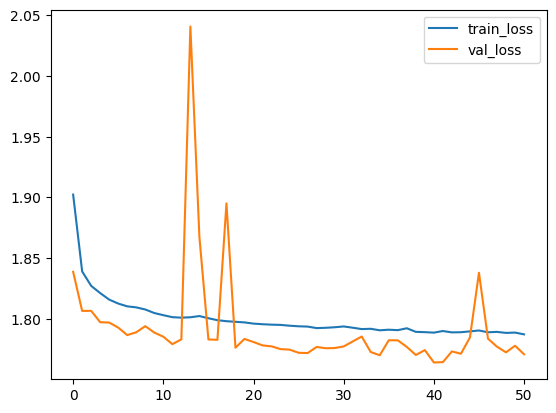

In [13]:
_ = log.plot()

In [14]:
log.to_pandas().val_loss.min()

1.764085292816162

In [15]:
model.score_in_batches(val)

{'loss': 1.764085292816162}

In [16]:
surv = model.predict_surv_df(x_test)

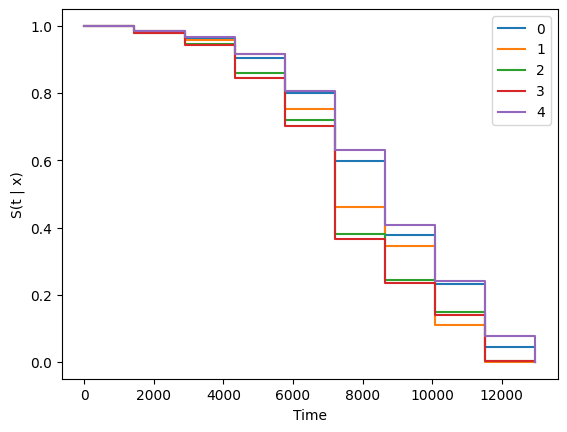

In [17]:
import matplotlib.pyplot as plt
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
surv = model.interpolate(10).predict_surv_df(x_test)

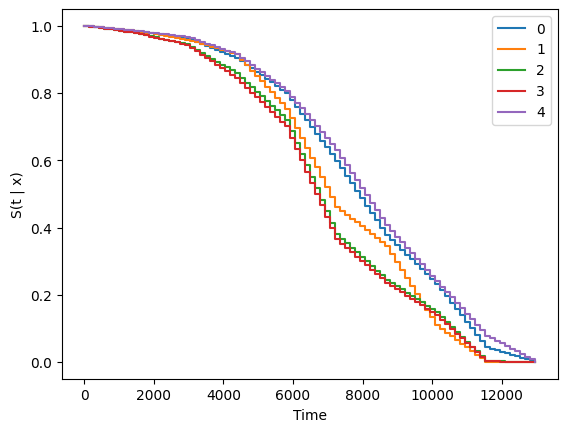

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
ev = EvalSurv(surv, durations_test, events_test.astype(int), censor_surv='km')

/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/pycox/utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -28.0. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


In [21]:
ev.concordance_td('antolini')

0.7174178513006971

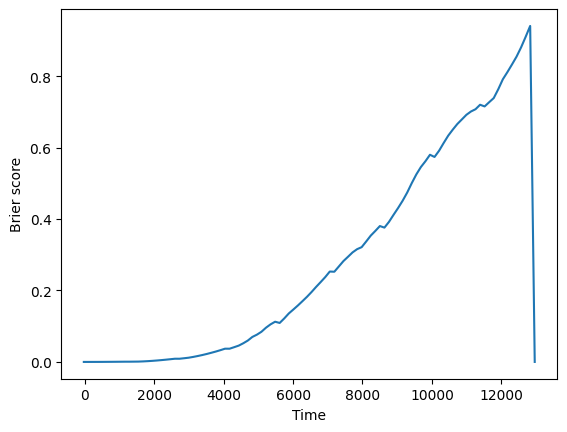

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [23]:
ev.integrated_brier_score(time_grid) 

0.28478674439384

In [24]:
ev.integrated_nbll(time_grid) 

0.856476485362989